In [1]:
# only if you are on google colab
%%capture
!pip3 install networkx

In [1]:
import networkx as nx
import random
import math

In [2]:
G = nx.Graph()

In [3]:
G.add_node(1,contracted=False)
G.add_node(2,contracted=False)
G.add_node(3,contracted=False)
G.add_node(4,contracted=False)
G.add_node(5,contracted=False)
G.add_node(6,contracted=False)
G.add_node(7,contracted=False)
G.add_node(8,contracted=False)
G.add_node(9,contracted=False)
G.add_node(10,contracted=False)
G.add_node(11,contracted=False)
G.add_node(12,contracted=False)
G.add_node(13,contracted=False)
G.add_node(14,contracted=False)

In [4]:
edges = [
    (1,2,{'weight':1}),
    (1,3,{'weight':4}),
    (1,7,{'weight':7}),
    (2,3,{'weight':5}),
    (2,4,{'weight':2}),
    (3,4,{'weight':2}),
    (3,6,{'weight':1}),
    (3,7,{'weight':2}),
    (3,8,{'weight':1}),
    (3,9,{'weight':1}),
    (4,5,{'weight':5}),
    (5,10,{'weight':7}),
    (6,7,{'weight':4}),
    (6,8,{'weight':3}),
    (6,10,{'weight':3}),
    (6,5,{'weight':3}),
    (6,9,{'weight':1}),
    (7,8,{'weight':6}),
    (8,9,{'weight':3}),
    (8,13,{'weight':5}),
    (9,12,{'weight':1}),
    (9,10,{'weight':3}),
    (10,11,{'weight':4}),
    (11,12,{'weight':3}),
    (11,13,{'weight':4}),
    (12,13,{'weight':2}),
    (14,1,{'weight':3}),
    (14,13,{'weight':2})
]

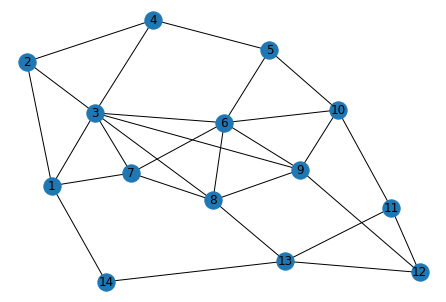

In [5]:
G.add_edges_from([*edges])
nx.draw(G,with_labels=True)

In [6]:
def dijkstra_with_contraction(G, source, destination, contracted = None):
    nx.set_node_attributes(G, {contracted: True}, 'contracted')
        
    shortest_path = dict()
    heap = list()
    
    for i in G.nodes():
        if not nx.get_node_attributes(G, 'contracted')[i]:
            shortest_path[i] = math.inf
            heap.append(i)
    shortest_path[source] = 0
    
    while len(heap) > 0:
        q = min(heap, key = lambda node : shortest_path[node])
        if q == destination:
            nx.set_node_attributes(G, {contracted: False}, 'contracted')
            return shortest_path[q]
        heap.remove(q)
        for v in G[q]:
            if not nx.get_node_attributes(G, 'contracted')[v]:
                distance = shortest_path[q] + G[q][v]['weight']
                if distance < shortest_path[v]:
                    shortest_path[v] = distance
    nx.set_node_attributes(G, {contracted: False}, 'contracted')
    return math.inf

In [7]:
shortest_paths = dict()
for i in G.nodes():
    shortest_paths[i] = dict()
    for j in G.nodes():
        shortest_paths[i][j] = dijkstra_with_contraction(G, i, j)

In [8]:
def calculate_edge_difference(G, shortest_paths):
    edge_difference = list()
    seenBefore = list()
    for i in G.nodes():
        edges_incident = len(G[i])

        contracted_node_paths = shortest_paths[i]
        del shortest_paths[i]

        new_graph = [*G.nodes()] # excluding the node that we have just contracted
        new_graph.remove(i)

        new_shortest_paths = dict()

        for source in new_graph:
            new_shortest_paths[source] = dict()
            for destination in new_graph:
                new_shortest_paths[source][destination] = dijkstra_with_contraction(G, \
                                                                                    source, \
                                                                                    destination, \
                                                                                    contracted = i)
        shortcuts = 0

        for source in new_shortest_paths:
            SP_contracted = new_shortest_paths[source]
            SP_original = shortest_paths[source]
            for destination in SP_contracted:
                if [source, destination] in seenBefore: continue
                seenBefore.append(sorted((source,destination)))
                if SP_contracted[destination] != SP_original[destination]:
                    shortcuts += 1

        shortest_paths[i] = contracted_node_paths

        ED = shortcuts - edges_incident
        edge_difference.append((i, ED))
    return edge_difference

In [9]:
edge_difference = calculate_edge_difference(G, shortest_paths)

In [10]:
edge_difference.sort(key = lambda pair : pair[1])
edge_difference

[(8, -5),
 (7, -4),
 (10, -4),
 (5, -3),
 (11, -3),
 (2, 0),
 (14, 0),
 (1, 2),
 (6, 3),
 (13, 5),
 (4, 6),
 (12, 18),
 (9, 22),
 (3, 29)]

In [11]:
G.edges()

EdgeView([(1, 2), (1, 3), (1, 7), (1, 14), (2, 3), (2, 4), (3, 4), (3, 6), (3, 7), (3, 8), (3, 9), (4, 5), (5, 10), (5, 6), (6, 7), (6, 8), (6, 10), (6, 9), (7, 8), (8, 9), (8, 13), (9, 12), (9, 10), (10, 11), (11, 12), (11, 13), (12, 13), (13, 14)])

In [12]:
current_graph = [*G.nodes()]

for node_ED in edge_difference:
    node = node_ED[0]
    nx.set_node_attributes(G, {node: True}, 'contracted')
    
    # we have already contracted the node
    # so there is no need 
    new_graph = current_graph
    new_graph.remove(node)
    current_shortest_paths = dict()
    for source in new_graph:
            current_shortest_paths[source] = dict()
            for destination in new_graph:
                current_shortest_paths[source][destination] = dijkstra_with_contraction(G, \
                                                                                    source, \
                                                                                    destination)
    # edge ordering heurisitc works ver
    for source in current_shortest_paths:
        SP_contracted = current_shortest_paths[source]
        SP_original = shortest_paths[source]
        for destination in SP_contracted:
            if source == destination: continue
            if SP_contracted[destination] != SP_original[destination]:
                # adding edge from 1 to 2 OR from 2 to 1 is the same thing in networkx
                # so we don't need to overcomplicate our code to handle repetitive edges
                # networkx does it on its own
                print(source, destination, node, SP_original[destination], SP_contracted[destination])
                G.add_edge(source, destination, weight=SP_original[destination])
                
    
    current_graph = new_graph

1 4 2 3 6
4 1 2 3 6
4 14 2 6 8
14 4 2 6 8
1 13 14 5 8
13 1 14 5 8


In [13]:
# adding edge from 1 to 2 OR 2 to 1 is the same thing
G.edges()

EdgeView([(1, 2), (1, 3), (1, 7), (1, 14), (1, 4), (1, 13), (2, 3), (2, 4), (3, 4), (3, 6), (3, 7), (3, 8), (3, 9), (4, 5), (4, 14), (5, 10), (5, 6), (6, 7), (6, 8), (6, 10), (6, 9), (7, 8), (8, 9), (8, 13), (9, 12), (9, 10), (10, 11), (11, 12), (11, 13), (12, 13), (13, 14)])

In [14]:
hierarchical_order = dict()
for order, node in enumerate(edge_difference):
    hierarchical_order[node[0]] = order

In [15]:
hierarchical_order

{8: 0,
 7: 1,
 10: 2,
 5: 3,
 11: 4,
 2: 5,
 14: 6,
 1: 7,
 6: 8,
 13: 9,
 4: 10,
 12: 11,
 9: 12,
 3: 13}

source is 8 and target is 12

# Dijkstra From Source

In [17]:
dist_s = dict()
heap_s = list()
for i in G.nodes():
    dist_s[i] = math.inf
    heap_s.append(i)
dist_s[10] = 0

# we will need this flag to know when
# to stop the search if we got stuck
# because of hierarchical ordering

stuck = False

while not stuck:
    stuck = True
    min_node = min(heap_s, key = lambda node : dist_s[node])
    heap_s.remove(min_node)
    order_parent = hierarchical_order[min_node]
    for child in G[min_node]:
        order_child = hierarchical_order[child]
        # from source we need the order of the child
        # to be bigger than the order of the parent
        # to relax that edge
        if order_child < order_parent: continue
        stuck = False
        distance = dist_s[min_node] + G[min_node][child]['weight']
        if distance < dist_s[child]:
            dist_s[child] = distance
        
        

In [18]:
dist_s

{1: inf,
 2: inf,
 3: 4,
 4: inf,
 5: 7,
 6: 3,
 7: inf,
 8: inf,
 9: 3,
 10: 0,
 11: 4,
 12: inf,
 13: inf,
 14: inf}

# Dijkstra From Target

In [19]:
dist_f = dict()
heap_f = list()
for i in G.nodes():
    dist_f[i] = math.inf
    heap_f.append(i)
dist_f[12] = 0


stuck = False

while not stuck:
    stuck = True
    min_node = min(heap_f, key = lambda node : dist_f[node])
    heap_f.remove(min_node)
    order_parent = hierarchical_order[min_node]
    for child in G[min_node]:
        order_child = hierarchical_order[child]
        # from source we need the order of the child
        # to be bigger than the order of the parent
        # to relax that edge
        if order_child < order_parent: continue
        stuck = False
        distance = dist_f[min_node] + G[min_node][child]['weight']
        if distance < dist_f[child]:
            dist_f[child] = distance

In [20]:
dist_f

{1: inf,
 2: inf,
 3: 2,
 4: inf,
 5: inf,
 6: inf,
 7: inf,
 8: inf,
 9: 1,
 10: inf,
 11: inf,
 12: 0,
 13: inf,
 14: inf}

We need to merge the common settled nodes from both `dist_f` and `dist_s` and see that shortest path and that is our shortest path

In [21]:
minimum = math.inf
merge_node = None
for i in dist_s:
    if dist_f[i] == math.inf: continue
    if dist_f[i] + dist_s[i] < minimum:
        minimum = dist_f[i] + dist_s[i]
        merge_node = i

In [22]:
minimum

4

let's use networkx algorithm to see if that is true or not 

In [23]:
from networkx.algorithms.shortest_paths.weighted import single_source_dijkstra

In [24]:
single_source_dijkstra(G,10,12)

(4, [10, 9, 12])

voila